In [1]:
import sys  
sys.path.insert(1, '.\..\..\SOURCES\.')

import random

random.seed(10)

from DATA import MG17
from Reservoir import Reservoir

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import numpy as np

In [3]:
data = MG17(True, [90,0,10])

X_TR, Y_TR = data.TR()
X_VAL, Y_VAL = data.VAL()
X_TS, Y_TS = data.TS()


In [4]:
from IPReservoir import IPReservoir
from ESN import EchoStateNetwork
from IPMask import IPMask
from Reservoir import Reservoir
from Metrics import *
from Evaluator import * 

In [5]:
N = 100
init_point = Reservoir(N=N, desired_rho=0.7, bias = False,)
names = ["Gaussian", "Bimodal", "Soft Trimodal", "Edgy Trimodal"]

masks = [
    IPMask.gaussian(N, std=0.2),
    IPMask.bimodal(N, mu=0.85, std=0.15),
    IPMask.trimodal(N, linear_rate=0.4, std_bim=0.18), # 
    IPMask.trimodal(N, linear_rate=0.2, mu=0.85, std_bim=0.1)
    ]

models = [IPReservoir.clone(init_point) for _ in range(len(names))]

for mask,model in zip(masks, models): 
    model.set_IP_mask(mask)

In [6]:
results = []

In [7]:
columns = ["Model Idx", "DeFi"]

In [8]:

for i,model in enumerate(models): 
    results.append( [i,DeltaPhi().evaluate(model)] )

In [ ]:
results

[[0, 0.21591877937316895],
 [1, 0.4139234125614166],
 [2, 0.3563474416732788],
 [3, 0.4205801784992218],
 [0, 0.18390314280986786],
 [1, 0.49725255370140076],
 [2, 0.36212605237960815],
 [3, 0.45854562520980835],
 [0, 0.17664195597171783],
 [1, 0.42845654487609863],
 [2, 0.2949911653995514],
 [3, 0.3826773166656494],
 [0, 0.19617533683776855],
 [1, 0.4476203918457031],
 [2, 0.3533882796764374],
 [3, 0.4018290936946869],
 [0, 0.22261252999305725],
 [1, 0.4954814910888672],
 [2, 0.39490795135498047],
 [3, 0.4710536599159241],
 [0, 0.18018217384815216],
 [1, 0.4646083414554596],
 [2, 0.3588477373123169],
 [3, 0.4316394627094269],
 [0, 0.20299769937992096],
 [1, 0.5175288915634155],
 [2, 0.3349741995334625],
 [3, 0.4474625885486603],
 [0, 0.21346493065357208],
 [1, 0.47625553607940674],
 [2, 0.353315144777298],
 [3, 0.43681633472442627],
 [0, 0.2201213538646698],
 [1, 0.4672144949436188],
 [2, 0.3775523900985718],
 [3, 0.4418119490146637]]

In [ ]:
df = pd.DataFrame(results, columns=columns)

In [ ]:
df.groupby("Model Idx").aggregate(["mean", "std"]).to_csv("INITIAL-KL.scv")

In [6]:
epochs = 15
eta = 0.0000025

In [7]:
columns = ["Name", "Model Idx", "Epoch", "KL", "Rho", "A-norm", "B-norm", "MC", "DeltaPhi", "MSE", "NRMSE" ]

In [8]:
for i,name in enumerate(names): 
    print(i, name)

0 Gaussian
1 Bimodal
2 Soft Trimodal
3 Edgy Trimodal


In [9]:
init_point.rho()

tensor(0.7000)

In [10]:
results = []
for e in range(epochs): 
    for idx, model in enumerate(models): 
        model.IP_online(X_TR, eta, 1, eval_kl=X_TS)
        row = [names[idx], idx, e+1, model.loss, model.rho(), model.a.norm(), model.b.norm(), MC().evaluate(model), DeltaPhi().evaluate(model), Evaluator.evaluate_estrinsic(init_point, data, MSE()), Evaluator.evaluate_estrinsic(init_point, data, NRMSE())]
        results.append(row)

In [12]:
np.array(results).shape

(60, 11)

In [13]:
df = pd.DataFrame(results, columns=columns )

In [14]:
# Function to convert tensors to float
def convert_to_float(tensor):
    return tensor.item() if isinstance(tensor, torch.Tensor) and tensor.shape == torch.Size([]) else tensor

# Apply the conversion function to the entire DataFrame
df = df.applymap(convert_to_float)

In [15]:
df.to_csv(".\TR_PLOTS.csv")

In [16]:
init_conditions = ["Initial Config", -1, 0, 0, 0.7, 1, 0, MC().evaluate(init_point), DeltaPhi().evaluate(init_point), Evaluator.evaluate_estrinsic(init_point, data, MSE()), Evaluator.evaluate_estrinsic(init_point, data, NRMSE() )]

In [17]:
init_conditions[7] = init_conditions[7].item()
init_conditions[9] = init_conditions[9].item()

In [18]:
init_conditions

['Initial Config',
 -1,
 0,
 0,
 0.7,
 1,
 0,
 10.436782836914062,
 0.2436068091216199,
 2.45745544165867e-07,
 0.07222309893771005]

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_evolution(attribute_name, palette='Set1'):
    attr_idx = columns.index(attribute_name)
    
    # Set Seaborn style and color palette
    sns.set(style='whitegrid')
    sns.set_palette(palette)

    # Group the DataFrame by "Model Idx"
    grouped_df = df.groupby('Model Idx')

    # Create a figure and axis
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)

    # Plot each group separately
    for model_idx, group in grouped_df:
        # Subtract the initial attribute value from each group of values
        group[attribute_name] = group[attribute_name] - group.loc[group['Epoch'].idxmin(), attribute_name] + init_conditions[attr_idx]
        ax.plot(group['Epoch'], group[attribute_name], label=f'{names[model_idx]}')

    # Set labels and title
    plt.xlabel('Epoch')
    plt.ylabel(columns[attr_idx])
    plt.title(f'{columns[attr_idx]} vs. Epoch for Different Model Idx')

    # Show legend
    plt.legend()

    # Show the plot
    plt.show()

# Example usage:
# plot_evolution('Rho', palette='viridis')

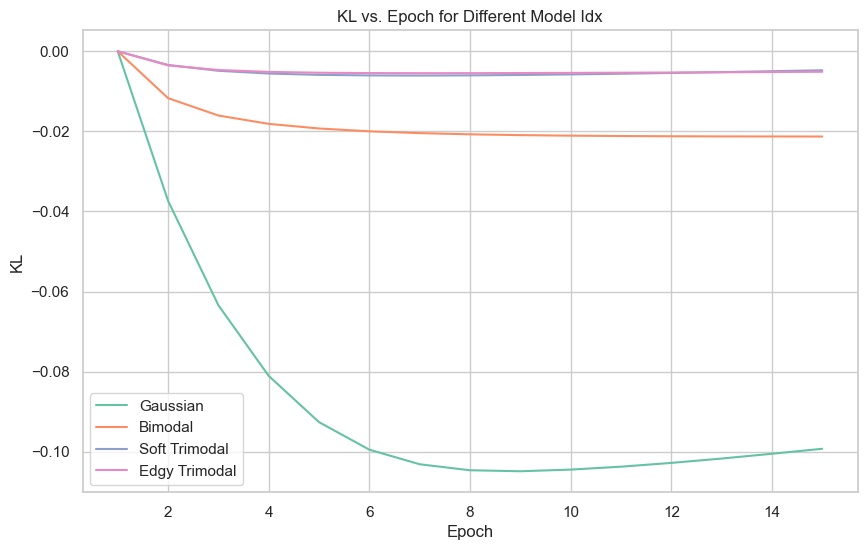

In [20]:
# Example usage:
plot_evolution('KL', palette='Set2')